In [1]:
# import
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from utils import jarque_bera_p_value, adf_p_value, load_file, DataFrame2DataLoader

import NN
import os
from torch import load as load_model
import config as cfg

In [2]:
# all data
dia_df = pd.read_csv("data/DIA.csv")
qqq_df = pd.read_csv("data/QQQ.csv")
spy_df = pd.read_csv("data/SPY.csv")

# adding suffix to all df
dia_df.columns=dia_df.columns.map(lambda x : x+'_dia' if x !='Date' else x)
qqq_df.columns=qqq_df.columns.map(lambda x : x+'_qqq' if x !='Date' else x)
spy_df.columns=spy_df.columns.map(lambda x : x+'_spy' if x !='Date' else x)

In [3]:
dfs = [dia_df, qqq_df, spy_df]

df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

# set date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
Training_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
Test_df = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
Out_of_sample_df = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

# Figure 1

In [58]:
ETF_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()

In [59]:
ETF_df

,Close_dia,Close_qqq,Close_spy
Date,,,
2011-01-03,116.410004,55.310001,127.050003
2011-01-04,116.639999,55.270000,126.980003
2011-01-05,117.040001,55.740002,127.639999
2011-01-06,116.779999,55.919998,127.389999
2011-01-07,116.570000,55.869999,127.139999
...,...,...,...
2015-04-07,178.419998,105.800003,207.279999
2015-04-08,178.750000,106.639999,207.979996
2015-04-09,179.399994,107.309998,208.899994


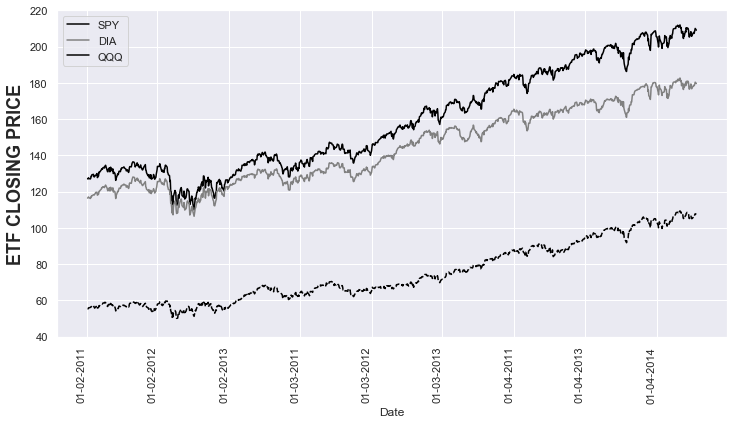

In [116]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(x=ETF_df.index, y='Close_spy', data=ETF_df, label="SPY", color='black')
sns.lineplot(x=ETF_df.index, y='Close_dia', data=ETF_df, label="DIA", color='grey')
sns.lineplot(x=ETF_df.index, y='Close_qqq', data=ETF_df, label="QQQ", color='black')

ax.lines[2].set_linestyle("--")

ax.set_ylabel('ETF CLOSING PRICE', fontsize=18, fontweight='bold')
ax.set(ylim=(40, 220))

x_dates = ETF_df.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');

plt.savefig('table/Figure1.png')

# Table 2

In [6]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                                     'STD':Adj_close_stats_df.apply(np.std),
                                     'Skew':Adj_close_stats_df.apply(skew),
                                     'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                                     'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False)),
#                                      'Jarque-Bera_t_stat':Adj_close_stats_df.apply(jarque_bera_t_stat),
                                     'Jarque-Bera_p_value':Adj_close_stats_df.apply(jarque_bera_p_value),
#                                      'ADF_t_stat':Adj_close_stats_df.apply(adf_t_stat),
                                     'ADF_p_value':Adj_close_stats_df.apply(adf_p_value)})
Table2 = Adj_close_Table.transpose()[['SPY', 'DIA', 'QQQ']]

Table2.to_csv("table/Table2.csv", index=True)
Table2

,SPY,DIA,QQQ
Mean,5.443915e-04,4.971633e-04,6.659312e-04
STD,9.592380e-03,8.863505e-03,1.052343e-02
Skew,-5.687756e-01,-5.178219e-01,-4.048366e-01
Fisher_Kurtosis,5.238305e+00,4.371469e+00,3.177268e+00
Pearson_Kurtosis,8.238305e+00,7.371469e+00,6.177268e+00
Jarque-Bera_p_value,0.000000e+00,0.000000e+00,0.000000e+00
ADF_p_value,6.154752e-30,8.649508e-30,7.087245e-19


In [7]:
# Correlation matrix (Spearman's rank)
Spearman_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="spearman")

Spearman_corr.to_csv("table/Spearman_correlation.csv", index=True)
Spearman_corr

,SPY,DIA,QQQ
SPY,1.000000,0.955254,0.887686
DIA,0.955254,1.000000,0.805231
QQQ,0.887686,0.805231,1.000000


In [8]:
# Correlation matrix (Pearson's method)
Pearson_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="pearson")

Pearson_corr.to_csv("table/Pearson_correlation.csv", index=True)
Pearson_corr

,SPY,DIA,QQQ
SPY,1.000000,0.972872,0.926548
DIA,0.972872,1.000000,0.871434
QQQ,0.926548,0.871434,1.000000


# Table 3

In [117]:
# Table 3
datasets = ["Total data-set", "Training data-set", "Test data-set", "Out-of-sample data-set"]
trading_days = [len(Total_df), len(Training_df), len(Test_df), len(Out_of_sample_df)]
start_date = [Total_df.index[0].strftime('%d/%m/%Y'), Training_df.index[0].strftime('%d/%m/%Y'), Test_df.index[0].strftime('%d/%m/%Y'), Out_of_sample_df.index[0].strftime('%d/%m/%Y')]
end_date = [Total_df.index[-1].strftime('%d/%m/%Y'), Training_df.index[-1].strftime('%d/%m/%Y'), Test_df.index[-1].strftime('%d/%m/%Y'), Out_of_sample_df.index[-1].strftime('%d/%m/%Y')]

Table3 = pd.DataFrame({"Datasets":datasets, "Trading days":trading_days, "Start date":start_date, "End date": end_date})

Table3.to_csv("table/Table3.csv", index=False)
Table3

,Datasets,Trading days,Start date,End date
0,Total data-set,1075,03/01/2011,13/04/2015
1,Training data-set,502,03/01/2011,31/12/2012
2,Test data-set,252,02/01/2013,31/12/2013
3,Out-of-sample data-set,321,02/01/2014,13/04/2015


# Table 5

Pesaran-Timmermann test and Diebold Mariano test

In [13]:
# Pesaran-Timmermann test
#https://purehost.bath.ac.uk/ws/portalfiles/portal/189214729/Forecasting_directional_change.pdf
#https://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
#https://www.economicsnetwork.ac.uk/showcase/cook_directional
#
#
# Diebold Mariano test
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.

In [20]:
Table5 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"ETF":[ETF]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = modelloaded.testPT       
    Table5 = pd.concat([Table5,Table],ignore_index=True)
# Table5.to_csv("table/Table5.csv", index=True) 

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005540 | Test MAPE  : 1.100655 | Test RSME : 0.000054 | Test Theil-U 0.929284
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.006091 | Test MAPE  : 2.762408 | Test RSME : 0.000062 | Test Theil-U 0.736161
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005535 | Test MAPE  : 1.503290 | Test RSME : 0.000055 | Test Theil-U 0.858845
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2)

In [21]:
Table5

,ETF,MLP,RNN,PSN
0,SPY,101.472760,34.506263,68.707281
1,DIA,73.384838,47.603206,54.733460
2,QQQ,95.983499,24.562251,74.079547


In [5]:
ETF = "SPY"
NNtype = "MLP"

params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
else:
    inputs_lag = cfg.QQQfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"],
                  params["hidden_size"],
                  params["output_size"],
                  1000,#params["epochs"],
                  params["optim"],
                  params["lr"],
                  params["momentum"])
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005540 | Test MAPE  : 1.100655 | Test RSME : 0.000054 | Test Theil-U 0.929284


In [10]:
preds, targets = modelloaded.Getevaluation(dataloader)
y_pred = np.array(preds)
y_true = np.array(targets)

In [25]:
# copied from John Tsang https://github.com/johntwk/Diebold-Mariano-Test/blob/master/dm_test.py
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [26]:
import random

random.seed(123)
actual_lst = range(0,100)
pred1_lst = range(0,100)
pred2_lst = range(0,100)

actual_lst = random.sample(actual_lst,100)
pred1_lst = random.sample(pred1_lst,100)
pred2_lst = random.sample(pred2_lst,100)

rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MAD")
print(rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MSE")
print(rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="poly", power=4)
print(rt)

dm_return(DM=0.7156156473441304, p_value=0.4759131435790399)
dm_return(DM=0.8149537766612477, p_value=0.4170549576990228)
dm_return(DM=0.6542582453666764, p_value=0.5144624594094003)


In [38]:
ProbY, ProbY_hat, ProbZ, Prob_star, V, W

(0.5669781931464174,
 0.9003115264797508,
 0.5482866043613707,
 0.5536242854785959,
 0.000769858056096293,
 0.0004961334846239418)

In [39]:
PT

-0.3226233024430973

In [41]:
y_true[0], y_pred[0]

(-0.009629852138459682, 0.00030441582202911377)

In [50]:
Y[32], Y_hat[32]

(0.0, 0.0)

In [51]:
Z[32]

1.0

In [55]:
y_pred[32], y_true[32]

(-7.456541061401367e-05, -0.006643662229180336)

In [60]:
n = len(y_true)

dy = y_true.copy()
dy[dy < 0] = 0
dy[dy > 0] = 1

py = np.mean(dy)
qy = (py*(1-py))/n

dz = y_pred.copy()
dz[dz < 0] = 0
dz[dz > 1] = 1

pz = np.mean(dz)
qz = (pz*(1-pz))/n

p = py*pz + (1-py)*(1-pz)

v = (p*(1-p))/n
w = ((2*py-1)**2)*qz + ((2*pz-1)**2)*qy + 4*qy*qz

dyz = y_true*y_pred.copy()
dyz[dyz < 0] = 0
dyz[dyz > 0] = 1
pyz = np.mean(dyz)

PT = (pyz - p)/(v-w)**0.5

In [61]:
PT

101.4727597745054

In [6]:
modelloaded.testPT

101.4727597745054